# Tutorial 3 - Boosting Search via Symmetry Breaking, Implied Constraints, Randomisation, and Restarts 'NOTES Perso: inverse implied and redundent + 
revisit the exact parameters so that restars work) 

**Please do not read untill you fully finish the first 2 tutorials**

Congratulations! you are now level one constraint programmer: you know the basics on how to model a problem, how to display solutions, how to evaluate models, and how to choose a good branching strategy !! **I'm so proud of you!**

In this tutorial we slowly dive into advanced techniques. We also start to use arithmetic constraints and solve optimisation problems.

In [1]:
from config import setup
setup()

/Users/msiala/.local/lib/python3.7/site-packages/docplex/cp/__init__.py:30: RuntimeWarning: DOcplex.CP is supported by Python versions 2.7.9+, 3.4.x, 3.5.x and 3.6.x, not '3.7.6.final.0'. Use it at your own risk.
  warnings.warn(msg, RuntimeWarning)


## Golomb ruler

Your goal is to place $N$ marks on a ruler, such that no two marks are at the same distance and the total length of the ruler (the position of the last mark) is minimized. 

<div class="row" style="margin-top: 10px">
    <img src="display/images/Golomb_Ruler-4.svg" style="display: block; margin: auto; width: 400px;" />
    <p style="margin: auto; margin-top: 10px; text-align: center;">Golomb ruler of order 4 and length 6. This ruler is both optimal and perfect.</p>
</div>

Golomb ruler can be used in information theory to design error correcting codes or in telecommunications to avoid interferences during radio communications. You can read about it here https://en.wikipedia.org/wiki/Golomb_ruler#:~:targetText=In%20mathematics%2C%20a%20Golomb%20ruler,are%20the%20same%20distance%20apart.&targetText=It%20has%20been%20proven%20that,of%20the%20same%20order%20exists.


**In the rest of this tutorial (except the last part), please use the following parameter with the solve method:**

```
SearchType= 'DepthFirst'
```

Also, in order to control the level of filtering (arc consistency, bound consistency, forward checking, etc), CPoptimizer offers to use a parameter called $DefaultInferenceLevel$  http://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.parameters.py.html?highlight=defaultinferencelevel#docplex.cp.parameters.CpoParameters.DefaultInferenceLevel

In the rest of this tutorial, you are required to test all three possibilities


```
DefaultInferenceLevel=Low
DefaultInferenceLevel=Medium
DefaultInferenceLevel=Extended

```

After a while, if you see one that you particularly find efficient (runtime), you can use it for the rest of the tutorial. 


Create a model for the decision version of this problem. That is, given $n$ marks, and a ruler of size $m$, place the $n$ markers such that no two markers are at the same distance. 

You are free to use any constraint you want. However, you must declare and use the minimum amount of constraints (**NOT A SINGLE UNNESSASARY CONSTRAINT**)

Note that for N marks, a ruler of length $2 ^ {N -1}$ can be found (I let you figure out why). 

Write a funtion decision_model(n,m) that builds and returns the correspondant model. 

In [2]:
from docplex.cp.model import CpoModel
from docplex.cp.modeler import all_diff, min, max
import numpy as np
import matplotlib.pyplot as plt

def decision_model(m,n):
    model = CpoModel(name="Golomb ruler of order {} and length {}".format(n,m))
    x = model.integer_var_list(n, 0, m, 'x')
    for i in range(n-1):
        model.add(x[i]<x[i+1])    
#     model.add(all_diff(x))  
    model.add(all_diff([x[j]-x[i] for i in range(n) 
                                    for j in range(i+1,n)])) 

    model.print_information()
    model.add(x[-1] == m)
    #model.add(x[0] == 0)
    
    return model,x

In [3]:
model,x = decision_model(6,4)
model.print_information()

Model: Golomb ruler of order 4 and length 6
 - expressions: 4
 - modeling time: 0.16 sec
Model: Golomb ruler of order 4 and length 6
 - expressions: 5
 - modeling time: 0.16 sec


Solve the problem for n=4, m=6. Then try different values of (n,m) (but don't waste too much time). 

In [4]:
sol = model.solve(SearchType='DepthFirst',  DefaultInferenceLevel='Low')
sol.print_solution()

-------------------------------------------------------------------------------
Model constraints: 5, variables: integer: 4, interval: 0, sequence: 0
Solve status: Feasible
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.0 sec
-------------------------------------------------------------------------------
x0: 0
x1: 1
x2: 4
x3: 6


You can display to solution using  :  

```
from display import golomb as display_golomb
display_golomb([sol[m] for m in marks])
```

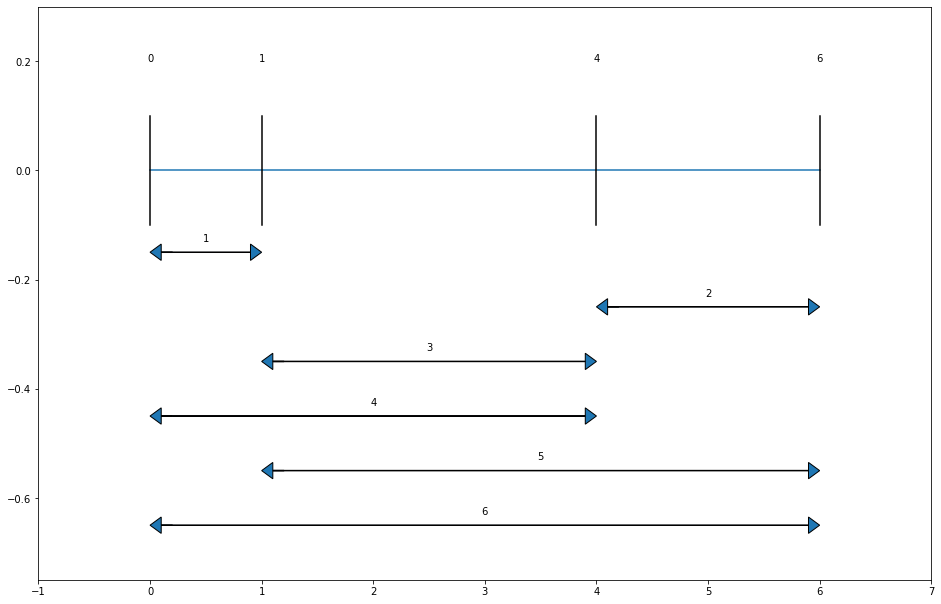

In [5]:
from display import golomb as display_golomb
display_golomb([sol[m] for m in x])

In [6]:
def run_and_display(m,n,InfLevel):
    model,x = decision_model(m,n)
    sol = model.solve(SearchType='DepthFirst',  DefaultInferenceLevel=InfLevel)
    if sol.get_solve_status() == 'Feasible':
        display_golomb([sol[m] for m in x])

        lsols = model.start_search(SearchType='DepthFirst',  DefaultInferenceLevel=InfLevel)
        nsol = 0
        for sol in lsols:
            nsol += 1
        print("Total nb of solutions : ", nsol)
    else:
        print('There is no solution!')

Print and display all the sulutions for (n,m) = (4,6) and (4,7)

Model: Golomb ruler of order 4 and length 6
 - expressions: 4
 - modeling time: 0.03 sec


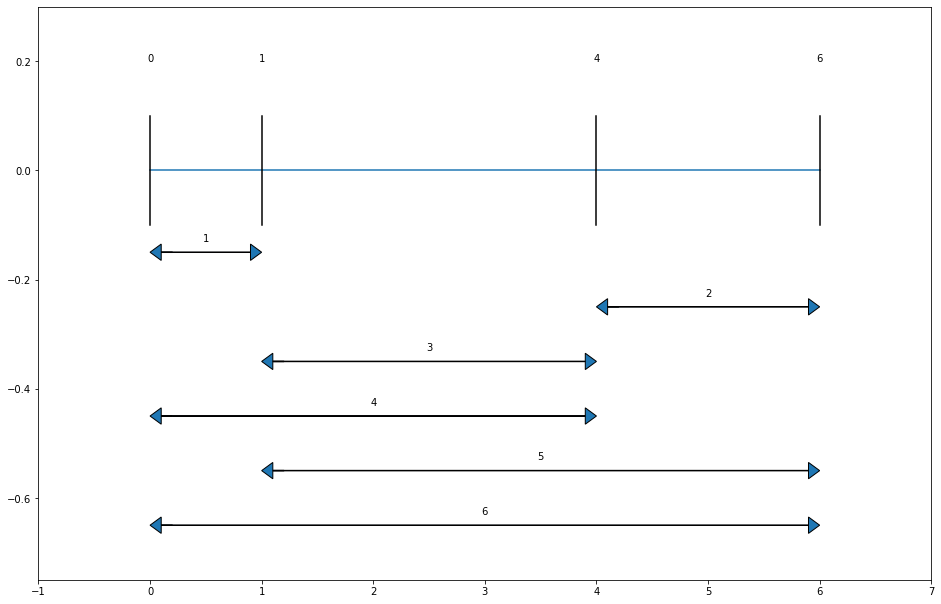

Total nb of solutions :  2


In [7]:
run_and_display(6,4,'Basic')

Model: Golomb ruler of order 4 and length 7
 - expressions: 4
 - modeling time: 0.03 sec


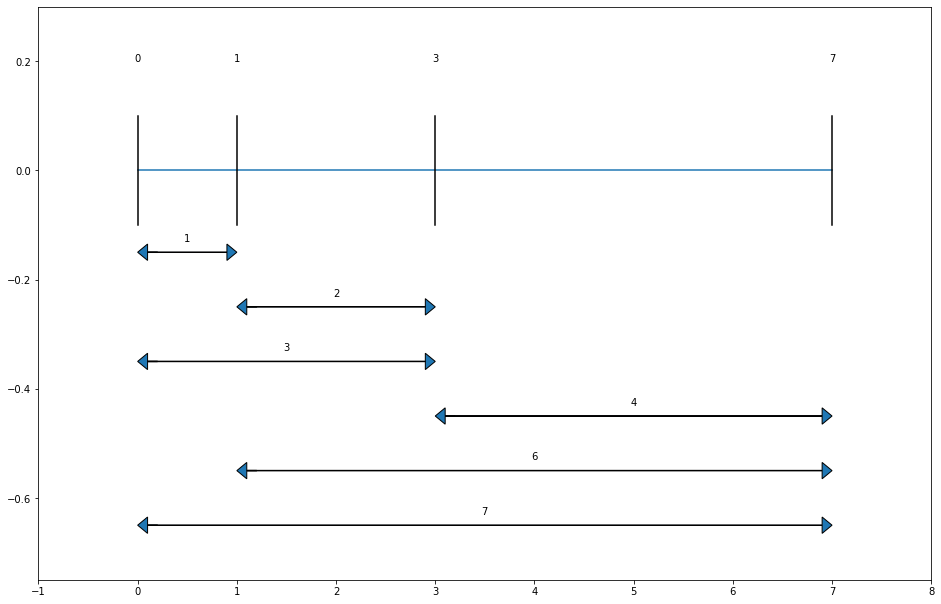

Total nb of solutions :  8


In [8]:
run_and_display(7,4,'Low')

In [9]:
run_and_display(10,5,'Basic')

Model: Golomb ruler of order 5 and length 10
 - expressions: 5
 - modeling time: 0.03 sec
There is no solution!


Write a funtion  basic_optimisation_model(n) that builds and returns the correspondant model for the
optimisation problem. Note that an optimisation function can be seen as a variable. In order to specify the variable to optimise, we can simply use : 

```
model.add(model.minimize(myvariable))
```

or 

```
model.add(model.maximize(myvariable))
```


In [10]:
def basic_optimisation_model(n):
    model = CpoModel(name="The shortest Golomb ruler of order {} ".format(n))
    x = model.integer_var_list(n, 0, n*n, 'x') ## G(n) <= n^2
    
    for i in range(n-1):
        model.add(x[i] < x[i+1]) 
    model.add(all_diff([x[i]-x[j] for i in range(n) for j in range(i)])) 

    model.add(model.minimize(x[-1]))
    return model,x

In [11]:
test_model, x  = basic_optimisation_model(6)
test_model.print_information()

Model: The shortest Golomb ruler of order 6 
 - expressions: 7
 - modeling time: 0.03 sec


-------------------------------------------------------------------------------
Model constraints: 6, variables: integer: 6, interval: 0, sequence: 0
Solve status: Optimal
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (17,)
          bounds: (0,)
          gaps: (1,)
x0: 0
x1: 1
x2: 4
x3: 10
x4: 12
x5: 17


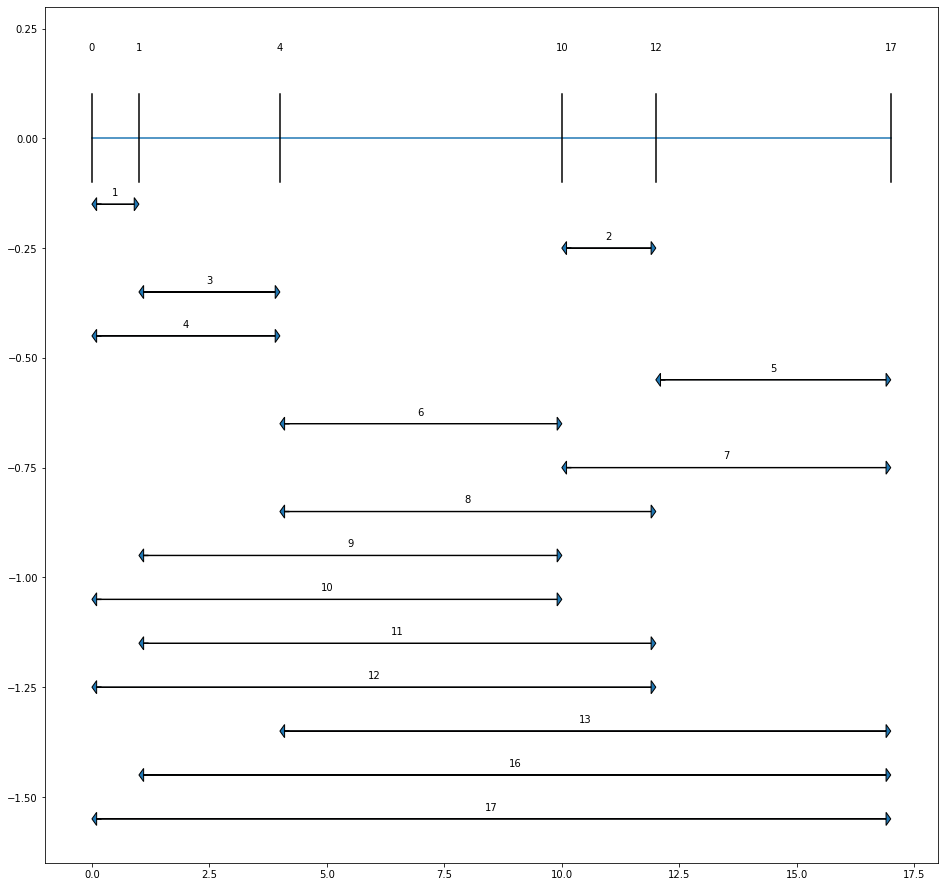

In [12]:
sol = test_model.solve(SearchType='DepthFirst',  DefaultInferenceLevel='Low')
sol.print_solution()
display_golomb([sol[m] for m in x])

In [13]:
sol.get_objective_values()[0]

17

Solve the optimisation problem for N=6.. 10  and display the solution

In [14]:
def run_basic_model(n,InfLevel):
    print("Build basic model...")
    model,x = basic_optimisation_model(n)
    sol = model.solve(SearchType='DepthFirst',  DefaultInferenceLevel=InfLevel)
    # sol.print_solution()
    infos = sol.get_solver_infos()
    if sol.get_solve_status() == 'Optimal':
        print("The shortest Golomb ruler of order {} is = {}, total execution time = {}s".format(n,sol.get_objective_values()[0],infos['TotalTime']))
    else:
        print('There is no solution!')
    return model,x,sol

In [15]:
for n in range(4,10):
    _,_,_ = run_basic_model(n,'Low')

Build basic model...
The shortest Golomb ruler of order 4 is = 6, total execution time = 0s
Build basic model...
The shortest Golomb ruler of order 5 is = 11, total execution time = 0s
Build basic model...
The shortest Golomb ruler of order 6 is = 17, total execution time = 0.00999999s
Build basic model...
The shortest Golomb ruler of order 7 is = 25, total execution time = 0.0600002s
Build basic model...
The shortest Golomb ruler of order 8 is = 34, total execution time = 0.49s
Build basic model...
The shortest Golomb ruler of order 9 is = 44, total execution time = 5.11s


In [16]:
for n in range(4,10):
    _,_,_ = run_basic_model(n,'Medium')

Build basic model...
The shortest Golomb ruler of order 4 is = 6, total execution time = 0.00999999s
Build basic model...
The shortest Golomb ruler of order 5 is = 11, total execution time = 0s
Build basic model...
The shortest Golomb ruler of order 6 is = 17, total execution time = 0.00999999s
Build basic model...
The shortest Golomb ruler of order 7 is = 25, total execution time = 0.0400002s
Build basic model...
The shortest Golomb ruler of order 8 is = 34, total execution time = 0.37s
Build basic model...
The shortest Golomb ruler of order 9 is = 44, total execution time = 4.08s


In [17]:
for n in range(4,10):
    _,_,_ = run_basic_model(n,'Extended')

Build basic model...
The shortest Golomb ruler of order 4 is = 6, total execution time = 0s
Build basic model...
The shortest Golomb ruler of order 5 is = 11, total execution time = 0s
Build basic model...
The shortest Golomb ruler of order 6 is = 17, total execution time = 0s
Build basic model...
The shortest Golomb ruler of order 7 is = 25, total execution time = 0.0599999s
Build basic model...
The shortest Golomb ruler of order 8 is = 34, total execution time = 0.48s
Build basic model...
The shortest Golomb ruler of order 9 is = 44, total execution time = 4.73s


# Symmetry Breaking

In combinatorial optimisation, two (partial) solutions are called symmetric if we can find a transformation from one to the other. 
Consider our golomb ruler problem. Given any solution to the marks variables, if the first mark is not at index $0$, we can always shift everything to the left to start from $0$ and still have a solution. 

Constraint programming is extremely flexible to handle symmetries since they can be declared as constraints. 

In the case of the above symmetry, we can simply add 
```
model.add (marks[0]==0)
```

This problem has another symmetry, can you find it? In order to help you, display the solution for n=4 and m=6 for the decision problem. You should find 2 solutions that are essentially the same. Can you find the symmetry? How can we model this symmetry as a constraint? 

Model: Golomb ruler of order 4 and length 6
 - expressions: 4
 - modeling time: 0.03 sec


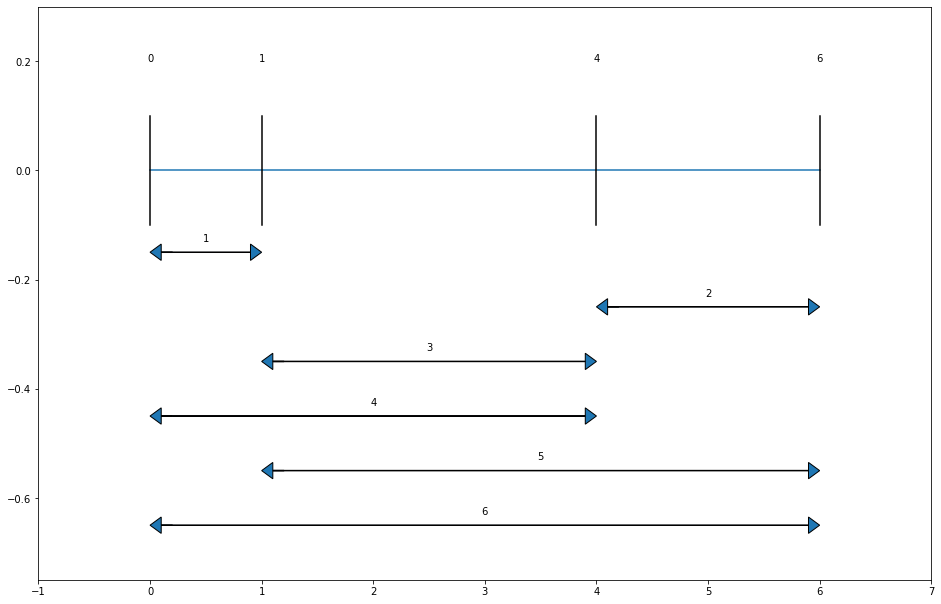

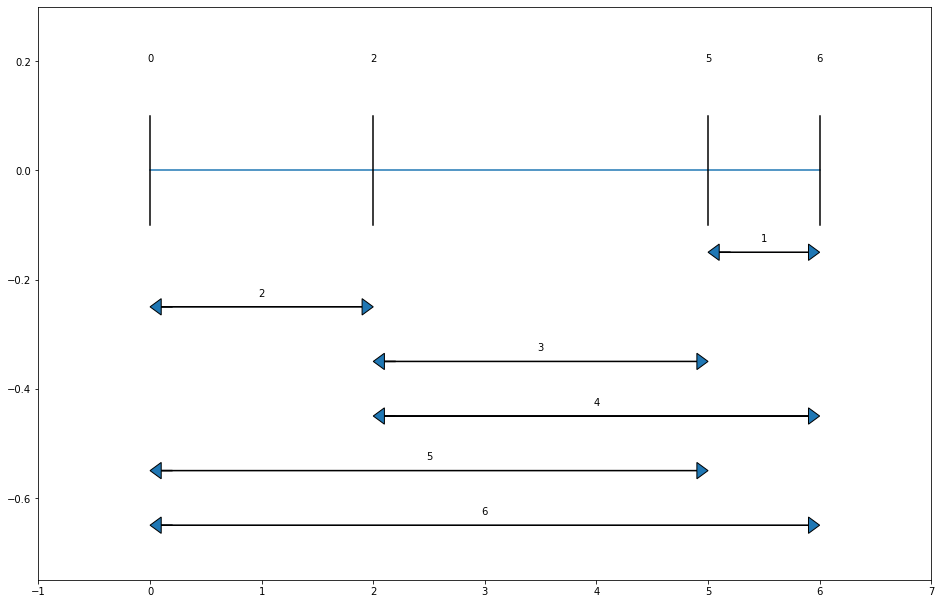

In [18]:
model,x = decision_model(6,4) 
lsols = model.start_search(SearchType='DepthFirst',  DefaultInferenceLevel='Low')
for sol in lsols:
    display_golomb([sol[m] for m in x])

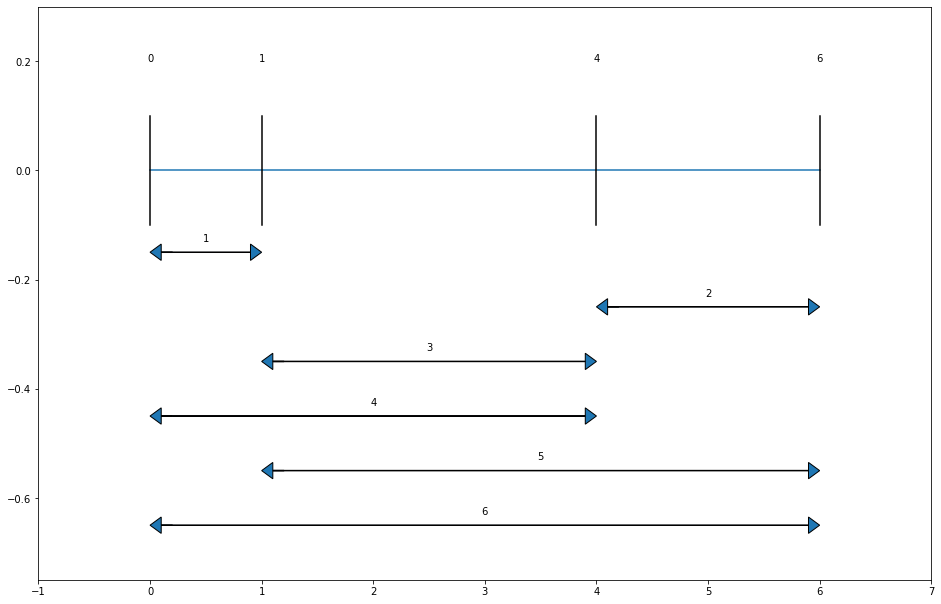

In [19]:
model.add(x[0] == 0)
model.add(x[1]-x[0] < x[-1]-x[-2])
lsols = model.start_search(SearchType='DepthFirst',  DefaultInferenceLevel='Low')
for sol in lsols:
    display_golomb([sol[m] for m in x])

Write a new function nosymmetry_optimisation_model(n) that builds a new model that avoids the two symmetries we found so far. 

In [34]:
def nosymmetry_optimisation_model(n):
    model = CpoModel(name="The shortest Golomb ruler of order {} - Symmetry Breaking".format(n))
    marks = model.integer_var_list(n, 0, n*n, 'x') ## G(n) <= n^2
    
    model.add(marks[0] == 0)
    for i in range(n-1):
        model.add(marks[i] < marks[i+1])
                         
    if n > 2 : 
        model.add(marks[1]-marks[0] < marks[n-1]-marks[n-2]) ## 2nd symmetry constraint
        
    model.add(all_diff([marks[i]-marks[j] for i in range(n) for j in range(i)])) 

    model.add(model.minimize(marks[n-1]))
    return model,marks

In [35]:
def run_nosymmetry_model(n,InfLevel):
    print("Build no symmetry model...")
    model,x = nosymmetry_optimisation_model(n)
    sol = model.solve(TimeLimit=120, LogPeriod = 100000,SearchType='DepthFirst',  DefaultInferenceLevel=InfLevel)
    infos = sol.get_solver_infos()
    if sol.get_solve_status() == 'Optimal':
        print("The shortest Golomb ruler of order {} is = {}, total execution time = {}s".format(n,sol.get_objective_values()[0],infos['TotalTime']))
    else:
        print('There is no solution!')
    return model,x,sol

Compare nosymmetry_optimisation_model and basic_optimisation_model for different values of $n$ (you decide the values of $n$). Plot the runtime and the search tree size

In [36]:
basic_runtime, nosym_runtime = [],[]
basic_treesize, nosym_treesize = [],[]
n_settings = np.arange(4,10,1)

for n in n_settings:
    _,_,basic_sol = run_basic_model(n,"Low")
    _,_,nosym_sol = run_nosymmetry_model(n,"Low")
    
    basic_runtime.append(basic_sol.get_solver_infos()['TotalTime'])
    basic_treesize.append(basic_sol.get_solver_infos()['NumberOfChoicePoints'])
    nosym_runtime.append(nosym_sol.get_solver_infos()['TotalTime'])
    nosym_treesize.append(nosym_sol.get_solver_infos()['NumberOfChoicePoints'])

Build basic model...
The shortest Golomb ruler of order 4 is = 6, total execution time = 0.02s
Build no symmetry model...
The shortest Golomb ruler of order 4 is = 6, total execution time = 0s
Build basic model...
The shortest Golomb ruler of order 5 is = 11, total execution time = 0s
Build no symmetry model...
The shortest Golomb ruler of order 5 is = 11, total execution time = 0s
Build basic model...
The shortest Golomb ruler of order 6 is = 17, total execution time = 0.00999999s
Build no symmetry model...
The shortest Golomb ruler of order 6 is = 17, total execution time = 0s
Build basic model...
The shortest Golomb ruler of order 7 is = 25, total execution time = 0.05s
Build no symmetry model...
The shortest Golomb ruler of order 7 is = 25, total execution time = 0.02s
Build basic model...
The shortest Golomb ruler of order 8 is = 34, total execution time = 0.53s
Build no symmetry model...
The shortest Golomb ruler of order 8 is = 34, total execution time = 0.14s
Build basic model.

What's your impression about symmetries? 

## Implied Constraints

An implied constraint is one that can be dedused by looking at the original constraints of the problem. 

For instance, if we have $a<b $ and $b<c$, one can infer that $a<c$. 

Such constraints (called also redundant constraints) can help the solver to prune further the search tree. 



In our problem there is an implied constraint. Can you find it? Please check with of the supervisors. 



Write a new function nosymmetry2_optimisation_model(n) that adds the implied constraint to the nosymmetry_optimisation_model(n) and returns the new model 

In [24]:
def nosymmetry2_optimisation_model(n):
    model = CpoModel(name="The shortest Golomb ruler of order {} - Symmetry Breaking".format(n))
    marks = model.integer_var_list(n, 0, n*n, 'x') ## G(n) <= n^2
    
    model.add(marks[0] == 0)
    for i in range(n-1):
        model.add(marks[i] < marks[i+1])
            
    if n > 2 :
        model.add(marks[1]-marks[0] < marks[n-1]-marks[n-2]) ## no symmetry constraint

    model.add(all_diff(marks))
    model.add(all_diff([marks[i]-marks[j] for i in range(n) for j in range(i)])) 
    
    model.add(model.minimize(marks[n-1]))
    return model,marks

In [25]:
def run_nosymmetry2_model(n,InfLevel):
    print("Build no symmetry model version 2 (with implied constraints)...")
    model,x = nosymmetry2_optimisation_model(n)
    sol = model.solve(TimeLimit=120, LogPeriod = 100000,SearchType='DepthFirst',  DefaultInferenceLevel=InfLevel)
    infos = sol.get_solver_infos()
    if sol.get_solve_status() == 'Optimal':
        print("The shortest Golomb ruler of order {} is = {}, total execution time = {}s".format(n,sol.get_objective_values()[0],infos['TotalTime']))
    else:
        print('There is no solution!')
    return model,x,sol

Compare nosymmetry2_optimisation_model and nosymmetry_optimisation_model 

In [26]:
nosym2_runtime, nosym_runtime = [],[]
nosym2_treesize, nosym_treesize = [],[]
n_settings = np.arange(4,12,1)

for n in n_settings:
    _,_,nosym_sol = run_nosymmetry_model(n,"Extended")
    _,_,nosym2_sol = run_nosymmetry2_model(n,"Extended")
    
    nosym_runtime.append(nosym_sol.get_solver_infos()['TotalTime'])
    nosym_treesize.append(nosym_sol.get_solver_infos()['NumberOfChoicePoints'])
    nosym2_runtime.append(nosym2_sol.get_solver_infos()['TotalTime'])
    nosym2_treesize.append(nosym2_sol.get_solver_infos()['NumberOfChoicePoints'])

Build no symmetry model...
The shortest Golomb ruler of order 4 is = 6, total execution time = 0.00999999s
Build no symmetry model version 2 (with implied constraints)...
The shortest Golomb ruler of order 4 is = 6, total execution time = 0s
Build no symmetry model...
The shortest Golomb ruler of order 5 is = 11, total execution time = 0s
Build no symmetry model version 2 (with implied constraints)...
The shortest Golomb ruler of order 5 is = 11, total execution time = 0s
Build no symmetry model...
The shortest Golomb ruler of order 6 is = 17, total execution time = 0s
Build no symmetry model version 2 (with implied constraints)...
The shortest Golomb ruler of order 6 is = 17, total execution time = 0.00999999s
Build no symmetry model...
The shortest Golomb ruler of order 7 is = 25, total execution time = 0.02s
Build no symmetry model version 2 (with implied constraints)...
The shortest Golomb ruler of order 7 is = 25, total execution time = 0.00999999s
Build no symmetry model...
The s

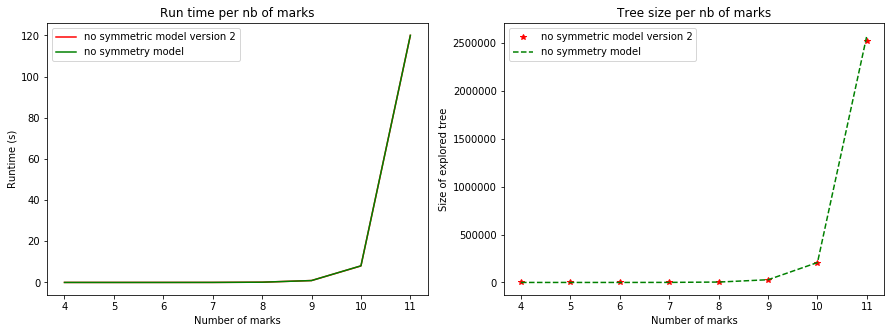

In [27]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(n_settings,nosym2_runtime,'r',label='no symmetric model version 2')
plt.plot(n_settings,nosym_runtime,'g',label='no symmetry model')
plt.xlabel("Number of marks")
plt.ylabel("Runtime (s)")
plt.legend(loc='best')
plt.title("Run time per nb of marks")

plt.subplot(122)
plt.plot(n_settings,nosym2_treesize,'r*',label='no symmetric model version 2')
plt.plot(n_settings,nosym_treesize,'g--',label='no symmetry model')
plt.xlabel("Number of marks")
plt.ylabel("Size of explored tree")
plt.title("Tree size per nb of marks")
plt.legend(loc='best')


plt.show()

# Randomisation and Restarts

Declare two search strategies: One that uses a lexicographical order on both variables and values, 
    and the other using an impact-based choice on the variables with a random value selection.     

Run the two strategies using the nosymmetry2_optimisation_model for different values of $n$

In [37]:
def run_both_strategies(n, SearchType='DepthFirst'):
    test_model_1,x = nosymmetry2_optimisation_model(n)
    ### Add strategy 1
    SearchPhase1 = test_model_1.search_phase(x, 
                                    varchooser=test_model_1.select_smallest(test_model_1.var_index(x)),
                                    valuechooser=test_model_1.select_smallest(test_model_1.value_index(np.arange(n))))
    test_model_1.add(SearchPhase1)
    ### Solve model
    sol_1 = test_model_1.solve(SearchType=SearchType,  DefaultInferenceLevel="Medium")


    test_model_2,x = nosymmetry2_optimisation_model(n)
    ### Add strategy 2
    SearchPhase2 = test_model_2.search_phase(x, 
                                    varchooser=test_model_2.select_smallest(test_model_2.var_impact()),
                                    valuechooser=test_model_2.select_random_value())
    test_model_2.add(SearchPhase2)
    ### Solve model
    sol_2 = test_model_2.solve(SearchType=SearchType,  DefaultInferenceLevel="Medium")
    return sol_1, sol_2

In [40]:
stra1_runtime, stra2_runtime = [],[]
stra1_treesize, stra2_treesize = [],[]
n_settings = np.arange(4,11,1)

for n in n_settings:
    sol_1,sol_2 = run_both_strategies(n,'DepthFirst')
    sol_1,sol_2 = run_both_strategies(n,'DepthFirst')
    
    stra1_runtime.append(sol_1.get_solver_infos()['TotalTime'])
    stra1_treesize.append(sol_1.get_solver_infos()['NumberOfChoicePoints'])
    stra2_runtime.append(sol_2.get_solver_infos()['TotalTime'])
    stra2_treesize.append(sol_2.get_solver_infos()['NumberOfChoicePoints'])

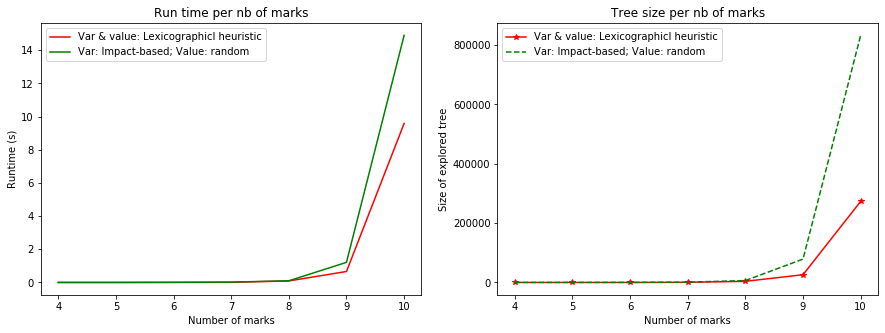

In [41]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(n_settings,stra1_runtime,'r',label='Var & value: Lexicographicl heuristic')
plt.plot(n_settings,stra2_runtime,'g',label='Var: Impact-based; Value: random')
plt.xlabel("Number of marks")
plt.ylabel("Runtime (s)")
plt.legend(loc='best')
plt.title("Run time per nb of marks")

plt.subplot(122)
plt.plot(n_settings,stra1_treesize,'r*-',label='Var & value: Lexicographicl heuristic')
plt.plot(n_settings,stra2_treesize,'g--',label='Var: Impact-based; Value: random')
plt.xlabel("Number of marks")
plt.ylabel("Size of explored tree")
plt.title("Tree size per nb of marks")
plt.legend(loc='best')


plt.show()

### The magic of restarts


Combinatorial search exhibits usually a bad behaviour in the runtime distribution called **heavy tailed phenomenon**. 
That is, at any node of the search tree, there is a non-negligeable probability that the time needed to explore the current subtree is heavier than 
an exponential distribution (you can read about it here https://aaai.org/Papers/AAAI/1998/AAAI98-061.pdf. 


A simple solution to deal with such a bad behaviour is to restart search from time to time. 
CPOptimizer offers this choice by using the parameter: 
    
```
    SearchType= 'Restart'
```



Using a restart search, evaluate the two strategies mentionned above using the nosymmetry2_optimisation_model for different values of $n$. What do you think?  

In [43]:
stra1_restart_runtime, stra2_restart_runtime = [],[]
stra1_restart_treesize, stra2_restart_treesize = [],[]
n_settings = np.arange(4,11,1)

for n in n_settings:
    sol_1,sol_2 = run_both_strategies(n,'Restart')
    sol_1,sol_2 = run_both_strategies(n,'Restart')
    
    stra1_restart_runtime.append(sol_1.get_solver_infos()['TotalTime'])
    stra1_restart_treesize.append(sol_1.get_solver_infos()['NumberOfChoicePoints'])
    stra2_restart_runtime.append(sol_2.get_solver_infos()['TotalTime'])
    stra2_restart_treesize.append(sol_2.get_solver_infos()['NumberOfChoicePoints'])

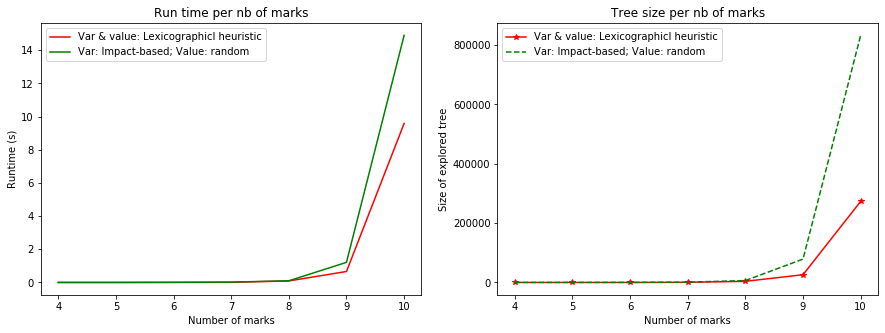

In [44]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(n_settings,stra1_runtime,'r',label='Var & value: Lexicographicl heuristic')
plt.plot(n_settings,stra2_runtime,'g',label='Var: Impact-based; Value: random')
plt.xlabel("Number of marks")
plt.ylabel("Runtime (s)")
plt.legend(loc='best')
plt.title("Run time per nb of marks")

plt.subplot(122)
plt.plot(n_settings,stra1_treesize,'r*-',label='Var & value: Lexicographicl heuristic')
plt.plot(n_settings,stra2_treesize,'g--',label='Var: Impact-based; Value: random')
plt.xlabel("Number of marks")
plt.ylabel("Size of explored tree")
plt.title("Tree size per nb of marks")
plt.legend(loc='best')


plt.show()

What is the maximum value of $n$ for which you can solve this problem? Use all your techniques! 

In [ ]:
### WARNING : This block takes a lot of time to execute
# A lot of configurations try for instance 


What did you learn today? 